In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import gc

In [ ]:
filename = os.listdir('/content/drive/MyDrive/Thuong/data574/image1_100')

path = []
for i in filename:
    path.append(os.path.join('/content/drive/MyDrive/Thuong/data574/image1_100',i))
len(path), path[0]

(100, '/content/drive/MyDrive/Thuong/data574/image1_100/280c26_0.png')

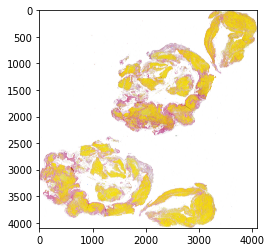

In [ ]:
img=cv2.imread(path[10],1)
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

In [ ]:
def normalizeStaining(img, saveFile=None, Io=240, alpha=1, beta=0.15):
    ''' Normalize staining appearence of H&E stained images
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
        
    Output:
        Inorm: normalized image
        H: hematoxylin image
        E: eosin image
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    maxCRef = np.array([1.9705, 1.0308])
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    img = img.reshape((-1,3))

    # calculate optical density
    OD = -np.log((img.astype(np.float)+1)/Io)
    
    # remove transparent pixels
    ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    #eigvecs *= -1
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # unmix hematoxylin and eosin
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

    return Inorm, H, E

In [ ]:
def remove_background(image):
    grayscale_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grayscale_img = 255 - grayscale_img
    thres, thres_img = 0,grayscale_img.copy()
    thres, thres_img = cv2.threshold(grayscale_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thres_img_not = cv2.bitwise_not(thres_img, mask = None)
    del thres_img
    gc.collect()
    
    img2 = np.zeros_like(image)
    img2[:,:,0] = thres_img_not
    img2[:,:,1] = thres_img_not
    img2[:,:,2] = thres_img_not
    
    foreground_img = cv2.bitwise_or(image, img2, mask = None)
    del thres_img_not, img2, image
    gc.collect()
    return foreground_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


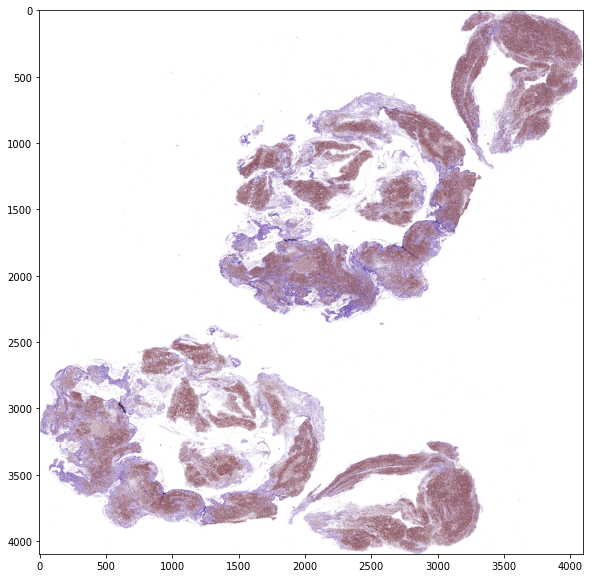

In [ ]:
Inorm, H, E = normalizeStaining(img)
Inorm.shape
Inorm_img = remove_background(Inorm)
Inorm_img = cv2.cvtColor(Inorm_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(Inorm_img)
plt.show()

In [ ]:
/content/drive/MyDrive/Thuong

In [ ]:
cv2.imwrite(f'./image/{filename[:-4]}.png', process_img)

In [ ]:
# Inorm_img = cv2.cvtColor(Inorm_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(Inorm_img)
plt.show()

error: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


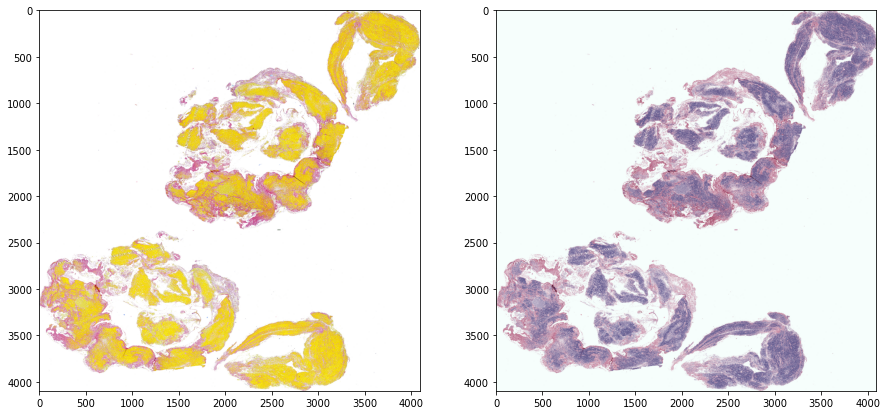

In [ ]:
img = cv2.imread(path[10],1)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

plt.subplot(122)
# plt.imshow(cv2.cvtColor(Inorm, cv2.COLOR_RGB2BGR))
plt.imshow(Inorm)
plt.show()

# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# plt.figure(figsize=(10,10))
# plt.subplot(221)
# # plt.figure(figsize=(20,10))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


# plt.subplot(222)
# plt.imshow(cv2.cvtColor(Inorm, cv2.COLOR_RGB2BGR))


# plt.subplot(223)
# plt.imshow(cv2.cvtColor(H, cv2.COLOR_RGB2BGR))


# plt.subplot(224)
# plt.imshow(cv2.cvtColor(E, cv2.COLOR_RGB2BGR))
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


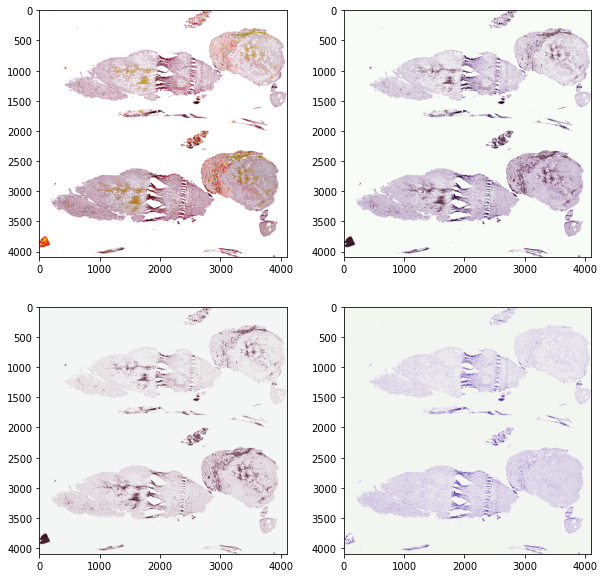

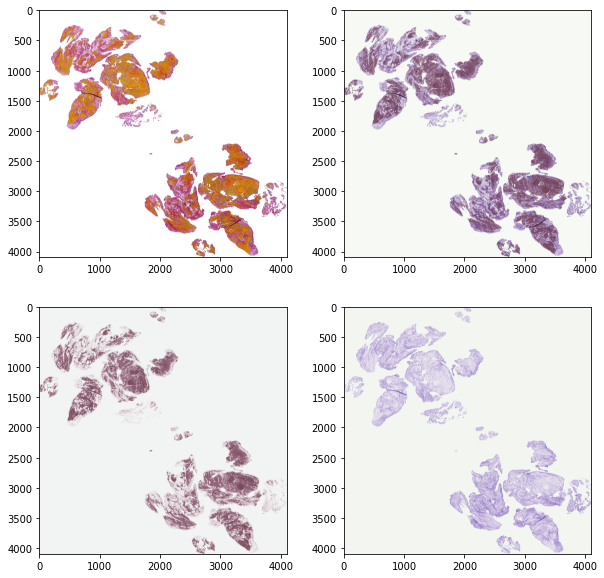

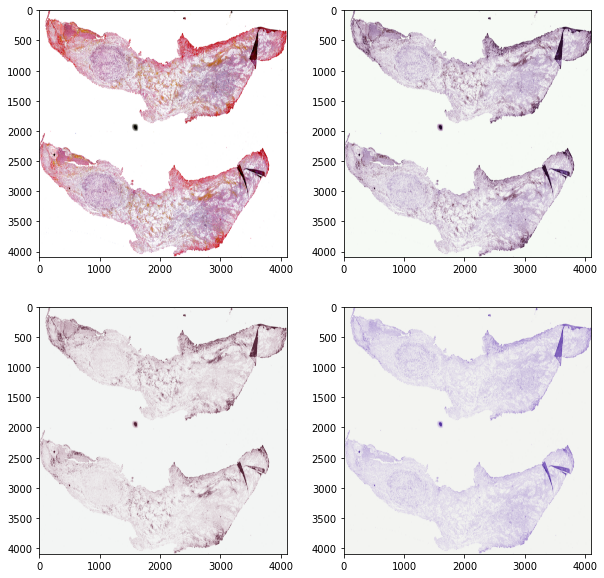

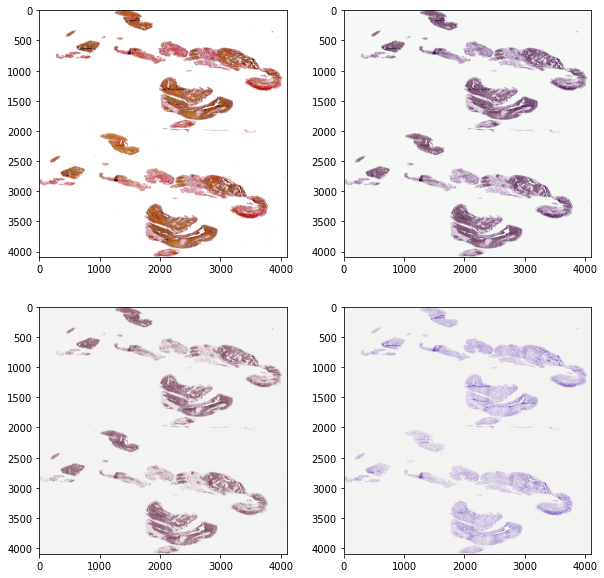

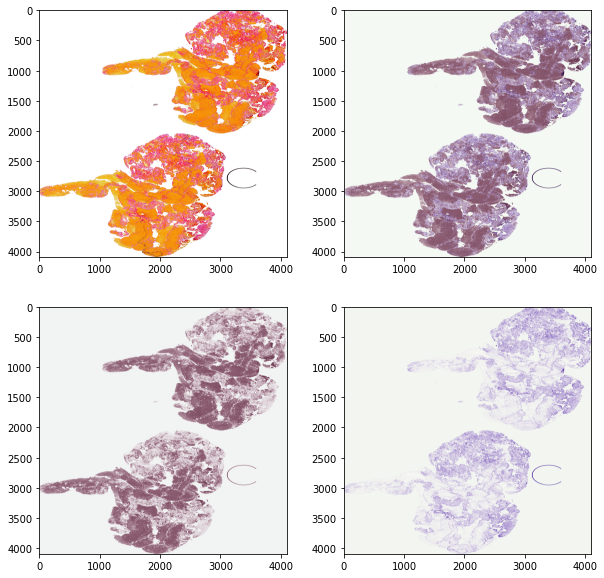

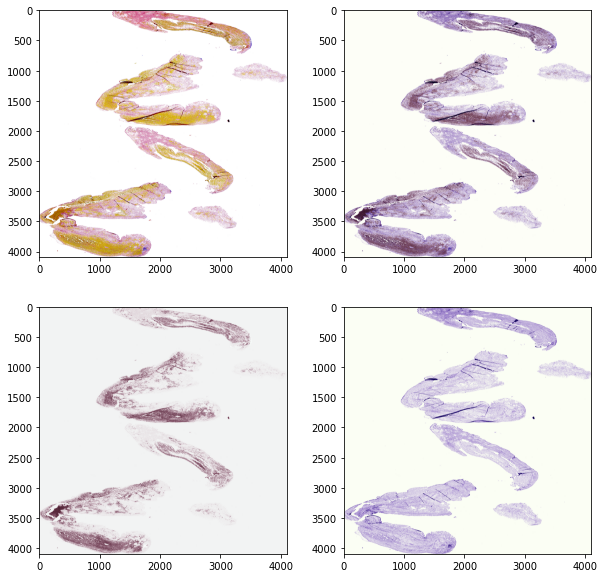

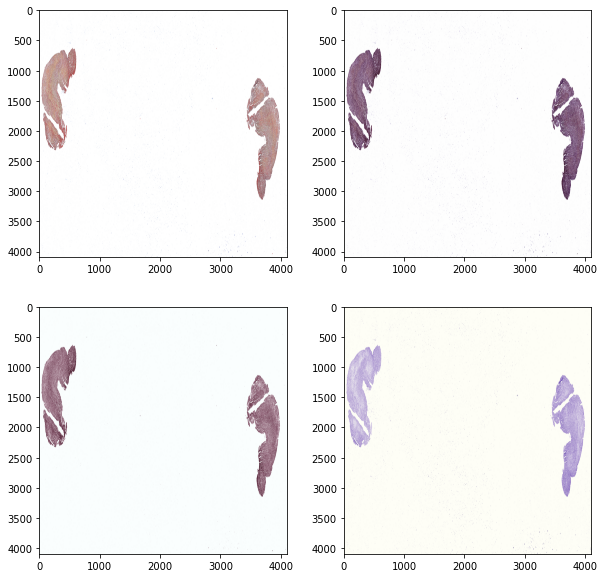

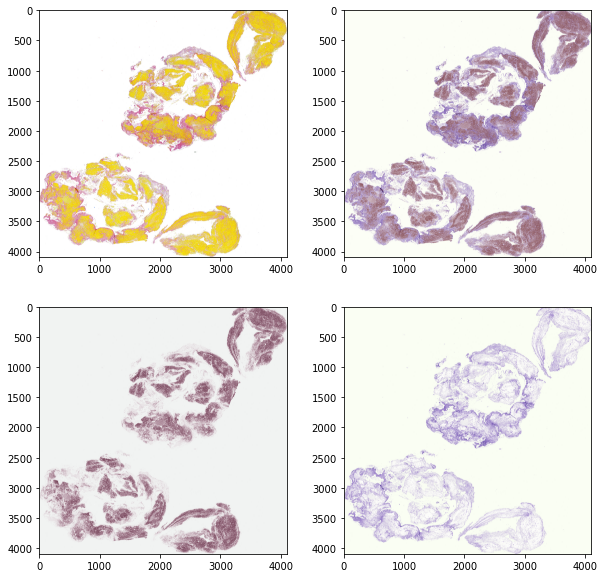

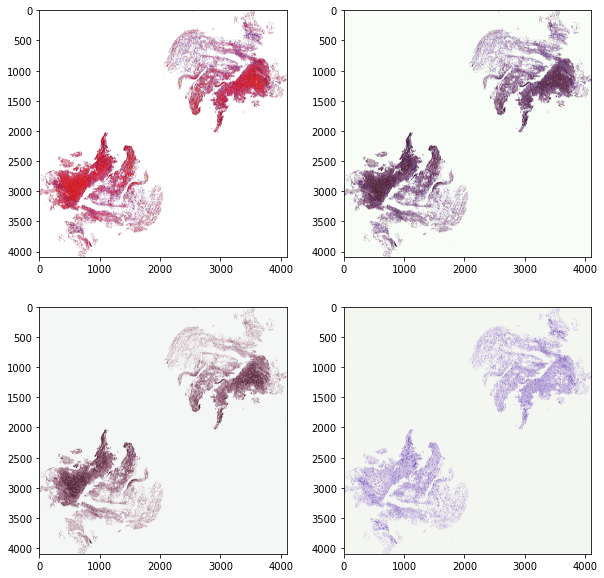

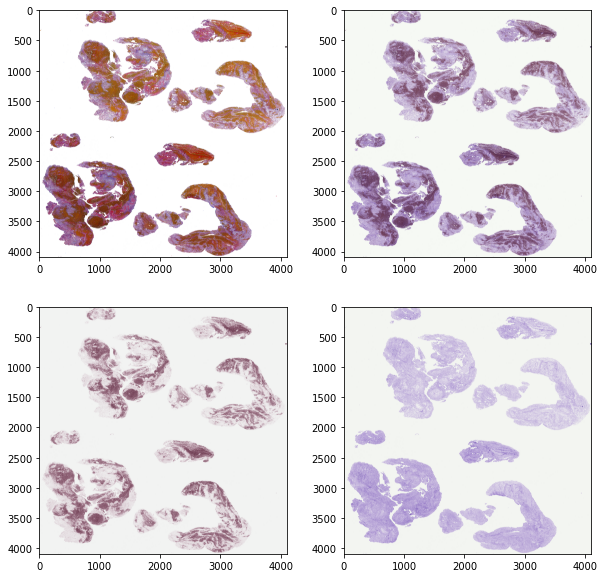

In [ ]:
for i in path:
    img = cv2.imread(i)
    Inorm, H, E = normalizeStaining(img)
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    # plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


    plt.subplot(222)
    plt.imshow(cv2.cvtColor(Inorm, cv2.COLOR_RGB2BGR))


    plt.subplot(223)
    plt.imshow(cv2.cvtColor(H, cv2.COLOR_RGB2BGR))


    plt.subplot(224)
    plt.imshow(cv2.cvtColor(E, cv2.COLOR_RGB2BGR))
    plt.show()

In [ ]:
cv2.imwrite('./test_img/abc1.png', Inorm)